# Time Series Forecasting - Temperature

In this notebook we will create a model to forecast temperature and comment it, data cleaning and handling were made in the ETL notebook.

The purpose here is to implement a simple neural network using LSTM, GRU and CNN(1d), learn how to use it and compare performance.

In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 23.1 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import zipfile
import urllib

import os
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Setting Seaborn Theme
sns.set_theme(style="whitegrid", font_scale=1.4)

plt.rcParams["figure.figsize"] = (15,9)

In [3]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

Here we will load preprocessed data ( cleaned and missing values handled)

In [5]:
# Reading cleaned dataframe
df = pd.read_csv('brasilia_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True,drop=True)
print(f"DataFrame Shape: {df.shape}")

# Getting a dataframe with only temperature
temperature_df = df['Temperature']

DataFrame Shape: (87672, 2)


First we will visualize data only for 2018-2020 in order to avoid a noisy chart.

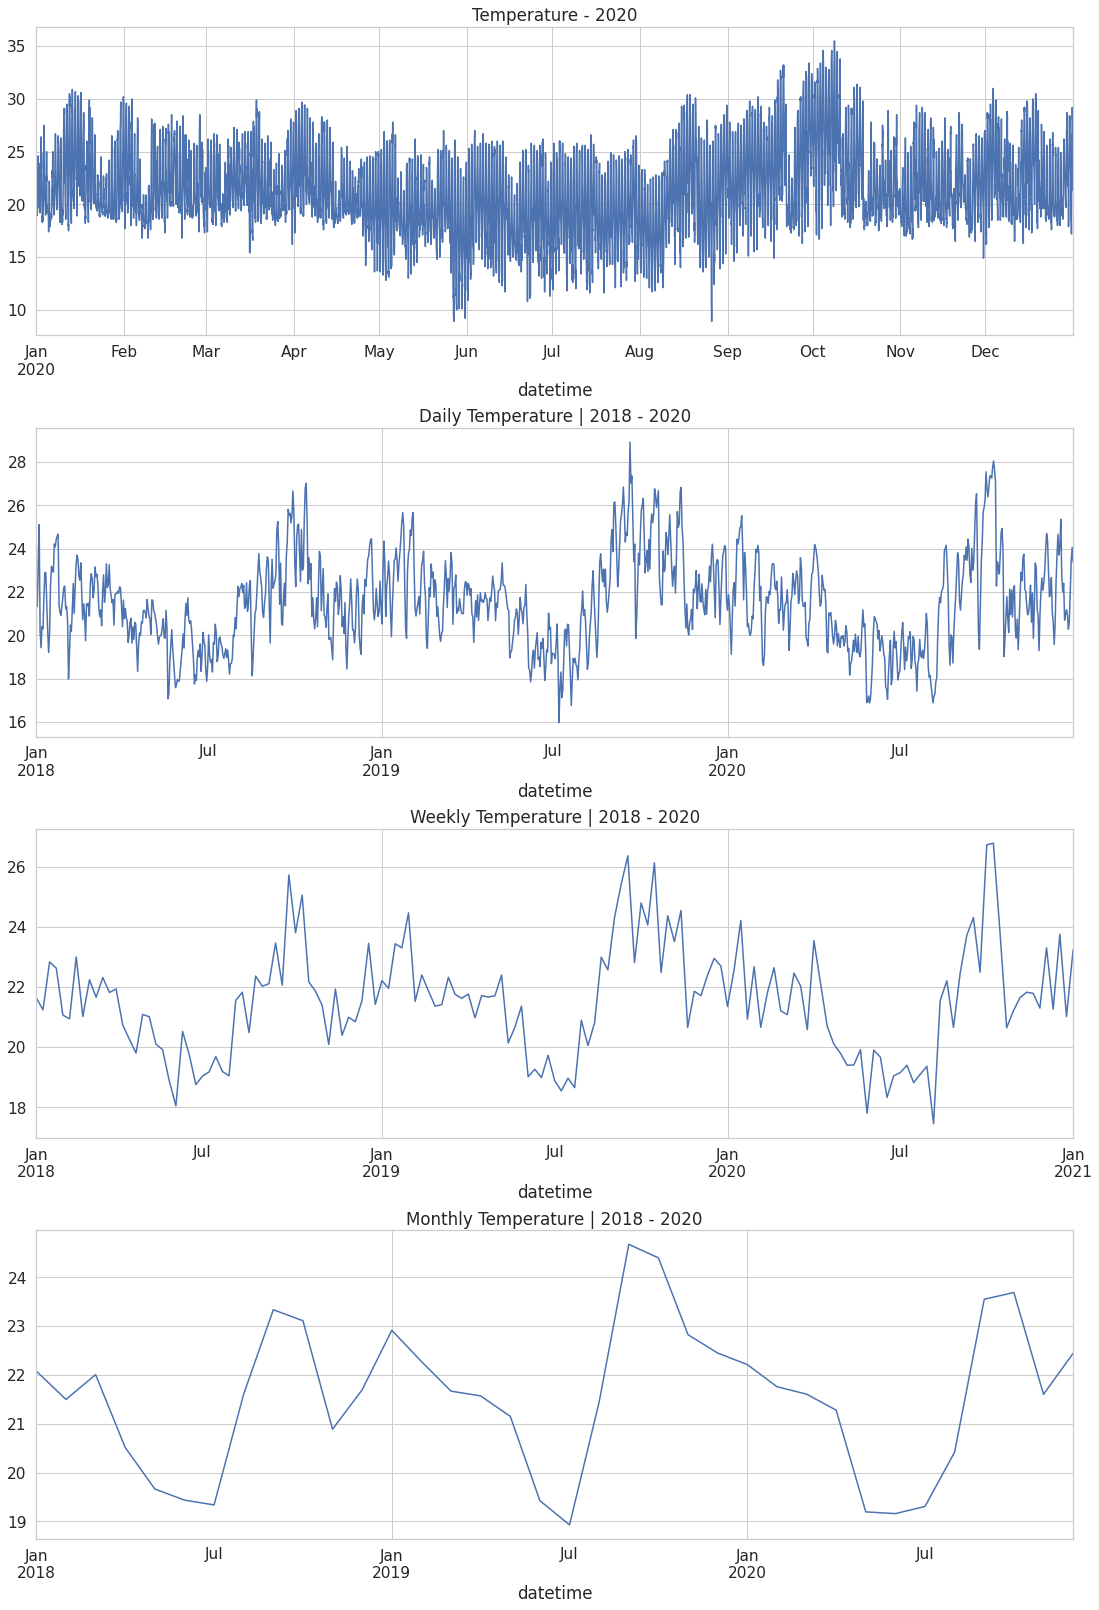

In [6]:
plt.rcParams["figure.figsize"] = (18,15)
fig1, axs = plt.subplots(nrows=4, ncols=1)

axs[0] = temperature_df['2020':].plot(ax = axs[0],title='Temperature - 2020')
axs[1] = temperature_df['2018':].resample('D').mean().plot(ax = axs[1], title='Daily Temperature | 2018 - 2020')
axs[2] = temperature_df['2018':].resample('W').mean().plot(ax = axs[2], title='Weekly Temperature | 2018 - 2020')
axs[3] = temperature_df['2018':].resample('M').mean().plot(ax = axs[3], title='Monthly Temperature | 2018 - 2020')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

We were using only 2018 to 2020 data but we can see some sort of seasonality , which is good to use prophet, but lets see how it will behave with LSTM.

In this LSTM/GRU/CNN it will be used sliding windows as input, default will be 5 hours to predict the next hour.

In [7]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def train_test_val_split(df, window_size=5):
    X, y = df_to_X_y(temperature_df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(temperature_df, 5)

________________________________________
    OUTPUT SHAPE

 X train: (70135, 5, 1)
 y train: (70135,)

 X val: (8766, 5, 1)
 y val: (8766,)

 X test: (8766, 5, 1)
 y test:(8766,)
________________________________________


In [16]:
def train_model_LSTM(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):

    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp1 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

    return model

def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(Conv1D(64, kernel_size=2))
    model.add(Flatten())
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))


    cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

    return model

def train_model_GRU(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(GRU(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp3 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp3])

    return model

In [24]:
def show_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name='LSTM'):
    print("_"*100)
    print(f"{model_name} Model".center(100, ' '))
    
    

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TRAIN DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_train,train_predictions)*100,2)}%')
    print('\n')
    print(train_results)
    train_results[:100].plot()
    plt.show()
    
    val_predictions = model.predict(X_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - VALIDATION DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_val,val_predictions)*100,2)}%')
    print('\n')
    print(val_results);
    val_results[:100].plot()
    plt.show()
    
    test_predictions = model.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TEST DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test,test_predictions)*100,2)}%')
    print('\n')
    print(test_results)
    test_results[:100].plot()
    plt.show()

In [11]:
model_LSTM = train_model_LSTM(X_train, y_train, X_val, y_val, 'model_LSTM', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 14s 5ms/step - loss: 91.0119 - root_mean_squared_error: 9.5400 - mean_absolute_percentage_error: 31.3338 - val_loss: 7.1790 - val_root_mean_squared_error: 2.6794 - val_mean_absolute_percentage_error: 8.9062


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 2/10
2192/2192 [==============================] - 12s 5ms/step - loss: 2.4274 - root_mean_squared_error: 1.5580 - mean_absolute_percentage_error: 5.2624 - val_loss: 1.6701 - val_root_mean_squared_error: 1.2923 - val_mean_absolute_percentage_error: 4.2446


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 3/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.2688 - root_mean_squared_error: 1.1264 - mean_absolute_percentage_error: 3.7642 - val_loss: 1.4255 - val_root_mean_squared_error: 1.1940 - val_mean_absolute_percentage_error: 4.0024


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 4/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1930 - root_mean_squared_error: 1.0923 - mean_absolute_percentage_error: 3.6376 - val_loss: 1.3763 - val_root_mean_squared_error: 1.1731 - val_mean_absolute_percentage_error: 3.9072


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 5/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1716 - root_mean_squared_error: 1.0824 - mean_absolute_percentage_error: 3.6034 - val_loss: 1.3696 - val_root_mean_squared_error: 1.1703 - val_mean_absolute_percentage_error: 3.8087


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 6/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1582 - root_mean_squared_error: 1.0762 - mean_absolute_percentage_error: 3.5742 - val_loss: 1.3296 - val_root_mean_squared_error: 1.1531 - val_mean_absolute_percentage_error: 3.7544


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 7/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1476 - root_mean_squared_error: 1.0712 - mean_absolute_percentage_error: 3.5508 - val_loss: 1.3707 - val_root_mean_squared_error: 1.1708 - val_mean_absolute_percentage_error: 3.7668
Epoch 8/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1382 - root_mean_squared_error: 1.0669 - mean_absolute_percentage_error: 3.5304 - val_loss: 1.3192 - val_root_mean_squared_error: 1.1486 - val_mean_absolute_percentage_error: 3.6861


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 9/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1320 - root_mean_squared_error: 1.0640 - mean_absolute_percentage_error: 3.5143 - val_loss: 1.3121 - val_root_mean_squared_error: 1.1455 - val_mean_absolute_percentage_error: 3.7006


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 10/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1305 - root_mean_squared_error: 1.0633 - mean_absolute_percentage_error: 3.5144 - val_loss: 1.3273 - val_root_mean_squared_error: 1.1521 - val_mean_absolute_percentage_error: 3.6935


In [17]:
model_GRU = train_model_GRU(X_train, y_train, X_val, y_val, 'model_GRU', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 14s 6ms/step - loss: 82.8722 - root_mean_squared_error: 9.1034 - mean_absolute_percentage_error: 28.2668 - val_loss: 4.2339 - val_root_mean_squared_error: 2.0576 - val_mean_absolute_percentage_error: 6.6562


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 2/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.7412 - root_mean_squared_error: 1.3196 - mean_absolute_percentage_error: 4.3175 - val_loss: 1.5412 - val_root_mean_squared_error: 1.2415 - val_mean_absolute_percentage_error: 4.0350


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 3/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.2286 - root_mean_squared_error: 1.1084 - mean_absolute_percentage_error: 3.6783 - val_loss: 1.4075 - val_root_mean_squared_error: 1.1864 - val_mean_absolute_percentage_error: 3.8155


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 4/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1785 - root_mean_squared_error: 1.0856 - mean_absolute_percentage_error: 3.6043 - val_loss: 1.3462 - val_root_mean_squared_error: 1.1603 - val_mean_absolute_percentage_error: 3.7994


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 5/10
2192/2192 [==============================] - 12s 6ms/step - loss: 1.1608 - root_mean_squared_error: 1.0774 - mean_absolute_percentage_error: 3.5749 - val_loss: 1.3346 - val_root_mean_squared_error: 1.1552 - val_mean_absolute_percentage_error: 3.7415


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 6/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1501 - root_mean_squared_error: 1.0724 - mean_absolute_percentage_error: 3.5508 - val_loss: 1.3275 - val_root_mean_squared_error: 1.1522 - val_mean_absolute_percentage_error: 3.7201


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 7/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1437 - root_mean_squared_error: 1.0694 - mean_absolute_percentage_error: 3.5396 - val_loss: 1.3274 - val_root_mean_squared_error: 1.1521 - val_mean_absolute_percentage_error: 3.7351


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 8/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1378 - root_mean_squared_error: 1.0667 - mean_absolute_percentage_error: 3.5246 - val_loss: 1.3626 - val_root_mean_squared_error: 1.1673 - val_mean_absolute_percentage_error: 3.7977
Epoch 9/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1350 - root_mean_squared_error: 1.0654 - mean_absolute_percentage_error: 3.5267 - val_loss: 1.3164 - val_root_mean_squared_error: 1.1473 - val_mean_absolute_percentage_error: 3.6680


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 10/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1329 - root_mean_squared_error: 1.0644 - mean_absolute_percentage_error: 3.5195 - val_loss: 1.3106 - val_root_mean_squared_error: 1.1448 - val_mean_absolute_percentage_error: 3.6770


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


In [18]:
model_conv1d = train_model_conv1d(X_train, y_train, X_val, y_val, 'model_conv1d', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 4s 2ms/step - loss: 12.3586 - root_mean_squared_error: 3.5155 - mean_absolute_percentage_error: 10.3349 - val_loss: 2.9202 - val_root_mean_squared_error: 1.7089 - val_mean_absolute_percentage_error: 5.9915
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 2/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.7963 - root_mean_squared_error: 1.3403 - mean_absolute_percentage_error: 4.5327 - val_loss: 1.6587 - val_root_mean_squared_error: 1.2879 - val_mean_absolute_percentage_error: 4.2059
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 3/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.3496 - root_mean_squared_error: 1.1617 - mean_absolute_percentage_error: 3.8250 - val_loss: 1.4647 - val_root_mean_squared_error: 1.2102 - val_mean_absolute_percentage_error: 3.8864
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 4/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2741 - root_mean_squared_error: 1.1288 - mean_absolute_percentage_error: 3.7287 - val_loss: 1.4308 - val_root_mean_squared_error: 1.1962 - val_mean_absolute_percentage_error: 3.8666
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 5/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2618 - root_mean_squared_error: 1.1233 - mean_absolute_percentage_error: 3.7397 - val_loss: 1.4280 - val_root_mean_squared_error: 1.1950 - val_mean_absolute_percentage_error: 3.9240
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 6/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2548 - root_mean_squared_error: 1.1202 - mean_absolute_percentage_error: 3.7473 - val_loss: 1.4362 - val_root_mean_squared_error: 1.1984 - val_mean_absolute_percentage_error: 3.8889
Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2511 - root_mean_squared_error: 1.1185 - mean_absolute_percentage_error: 3.7586 - val_loss: 1.4691 - val_root_mean_squared_error: 1.2121 - val_mean_absolute_percentage_error: 3.9423
Epoch 8/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2501 - root_mean_squared_error: 1.1181 - mean_absolute_percentage_error: 3.7614 - val_loss: 1.4223 - val_root_mean_squared_error: 1.1926 - val_mean_absolute_percentage_error: 3.8944
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2509 - root_mean_squared_error: 1.1184 - mean_absolute_percentage_error: 3.7697 - val_loss: 1.4834 - val_root_mean_squared_error: 1.2180 - val_mean_absolute_percentage_error: 3.9751
Epoch 10/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2516 - root_mean_squared_error: 1.1187 - mean_absolute_percentage_error: 3.7760 - val_loss: 1.4633 - val_root_mean_squared_error: 1.2097 - val_mean_absolute_percentage_error: 4.0753


In [19]:
model_LSTM = load_model('model_LSTM/')
model_GRU = load_model('model_GRU/')
model_conv1d = load_model('model_conv1d/')

## Model - LSTM

____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.5%


       Train Predictions  Actuals
0              17.678219     18.2
1              18.370872     17.8
2              17.987749     18.0
3              18.404335     17.9
4              18.267654     17.9
...                  ...      ...
70130          18.544676     18.2
70131          18.594425     18.4
70132          18.892107     18.0
70133          18.305603     18.7
70134          19.221455     19.0

[70135 rows x 2 columns]


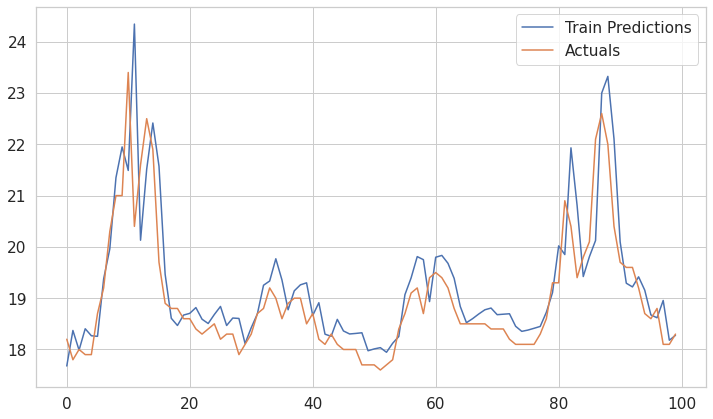




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.7%


      Val Predictions  Actuals
0           19.560196     19.6
1           20.308823     22.2
2           23.477247     24.2
3           25.307674     24.8
4           25.546665     23.4
...               ...      ...
8761        23.427776     24.0
8762        24.935808     22.8
8763        22.872198     21.6
8764        21.248571     24.6
8765        24.709887     24.5

[8766 rows x 2 columns]


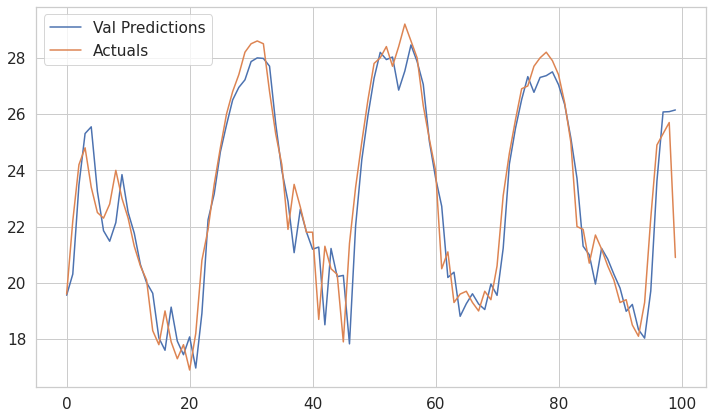




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.66%


      Test Predictions  Actuals
0            24.084530     20.0
1            20.042643     22.3
2            21.872213     23.9
3            23.648102     23.9
4            23.778999     21.7
...                ...      ...
8761         27.240818     28.1
8762         26.974796     23.6
8763         22.931633     23.6
8764         22.425716     22.3
8765         21.210009     21.3

[8766 rows x 2 columns]


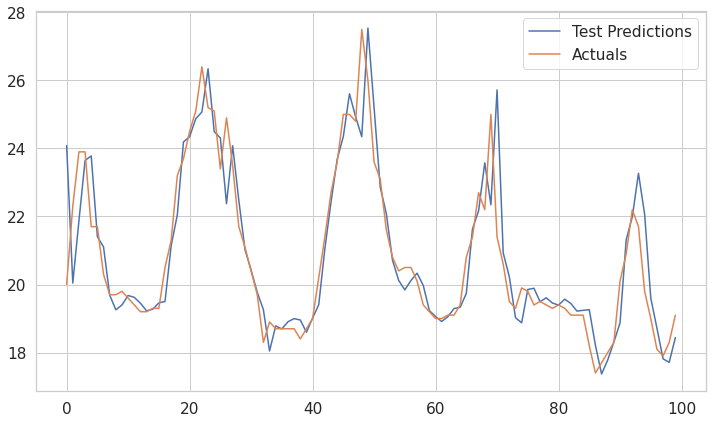

In [20]:
plt.rcParams["figure.figsize"] = (12,7)
show_model(model_LSTM, X_train, y_train, X_val, y_val, X_test, y_test)

## Model - GRU

____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.47%


       Train Predictions  Actuals
0              17.547470     18.2
1              18.400259     17.8
2              17.879322     18.0
3              18.258778     17.9
4              18.117342     17.9
...                  ...      ...
70130          18.492548     18.2
70131          18.468435     18.4
70132          18.748508     18.0
70133          18.114040     18.7
70134          19.169319     19.0

[70135 rows x 2 columns]


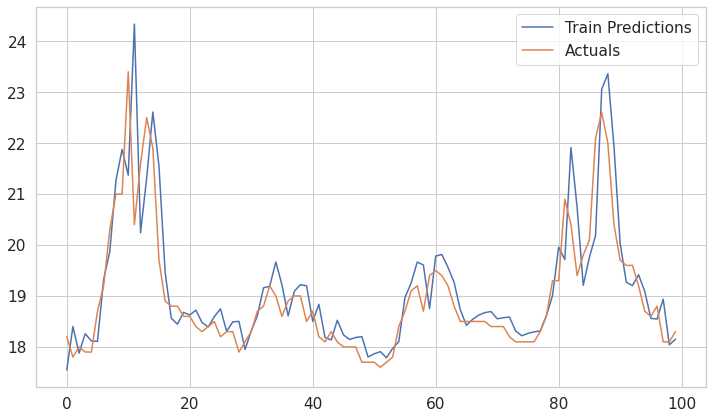




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.68%


      Val Predictions  Actuals
0           19.494888     19.6
1           20.223036     22.2
2           23.549416     24.2
3           25.380426     24.8
4           25.619370     23.4
...               ...      ...
8761        23.504829     24.0
8762        25.012650     22.8
8763        22.784904     21.6
8764        21.084204     24.6
8765        24.727329     24.5

[8766 rows x 2 columns]


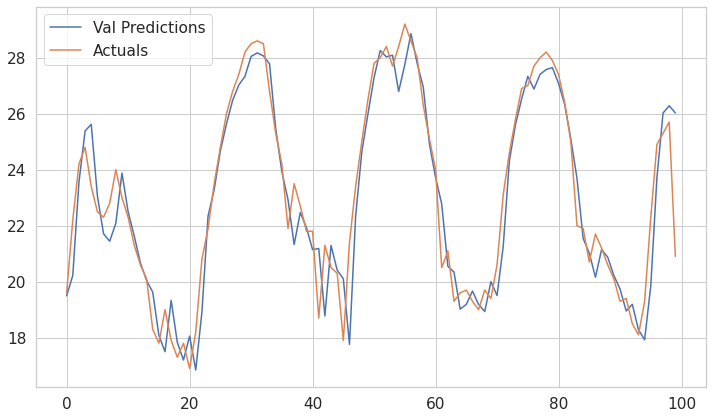




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.65%


      Test Predictions  Actuals
0            24.398865     20.0
1            20.280636     22.3
2            21.699163     23.9
3            23.992767     23.9
4            23.806255     21.7
...                ...      ...
8761         27.228958     28.1
8762         27.206100     23.6
8763         23.089020     23.6
8764         22.289604     22.3
8765         21.452957     21.3

[8766 rows x 2 columns]


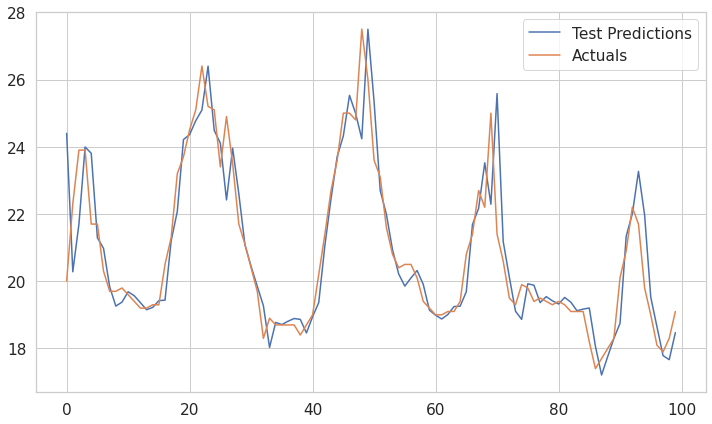

In [22]:
show_model(model_GRU, X_train, y_train, X_val, y_val, X_test, y_test, model_name='GRU')

## Model - Conv 1d

____________________________________________________________________________________________________
                                           Conv 1d Model                                            



____________________________________________________________________________________________________
                                     Conv 1d Model - TRAIN DATA                                     


MAPE: 3.71%


       Train Predictions  Actuals
0              17.806314     18.2
1              18.476278     17.8
2              18.073996     18.0
3              18.421865     17.9
4              18.326111     17.9
...                  ...      ...
70130          18.587948     18.2
70131          18.602804     18.4
70132          18.863991     18.0
70133          18.369606     18.7
70134          19.169220     19.0

[70135 rows x 2 columns]


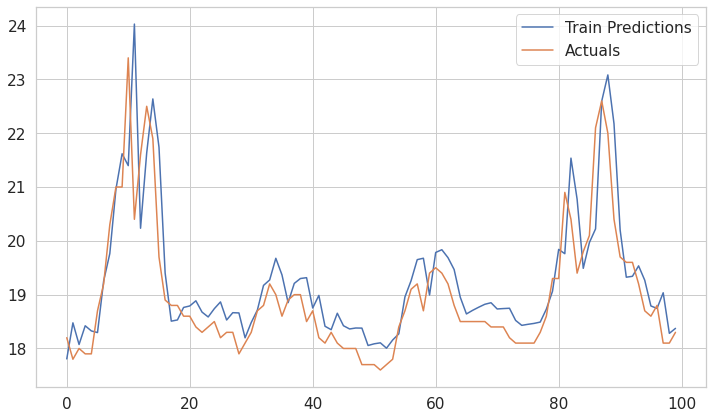




____________________________________________________________________________________________________
                                  Conv 1d Model - VALIDATION DATA                                   


MAPE: 3.89%


      Val Predictions  Actuals
0           19.478544     19.6
1           20.112375     22.2
2           23.061903     24.2
3           25.069162     24.8
4           25.400192     23.4
...               ...      ...
8761        23.044725     24.0
8762        24.678949     22.8
8763        22.979904     21.6
8764        21.392294     24.6
8765        24.759251     24.5

[8766 rows x 2 columns]


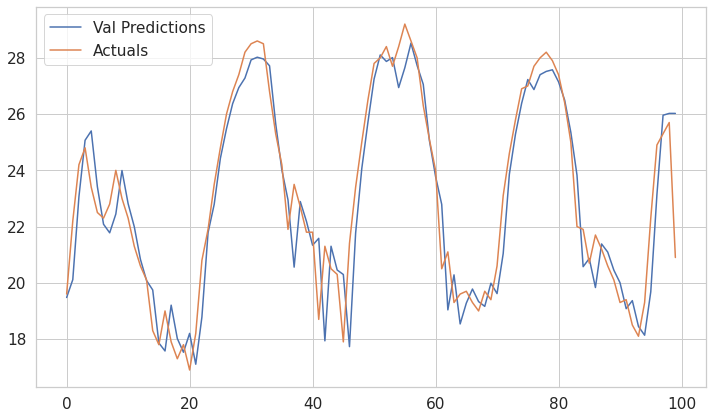




____________________________________________________________________________________________________
                                     Conv 1d Model - TEST DATA                                      


MAPE: 3.82%


      Test Predictions  Actuals
0            24.409187     20.0
1            19.203409     22.3
2            22.153419     23.9
3            23.828814     23.9
4            23.828886     21.7
...                ...      ...
8761         27.340292     28.1
8762         27.145397     23.6
8763         21.935873     23.6
8764         22.370104     22.3
8765         21.134520     21.3

[8766 rows x 2 columns]


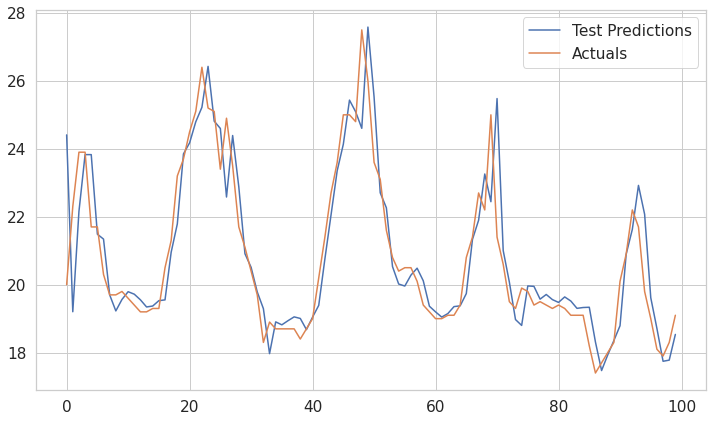

In [25]:
show_model(model_conv1d, X_train, y_train, X_val, y_val, X_test, y_test, model_name='Conv 1d')

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

In [ ]:
def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
  model = Sequential()
  model.add(InputLayer((5, 1)))
  model.add(Conv1D(64, kernel_size=2))
  model.add(Flatten())
  model.add(Dense(8, 'relu'))
  model.add(Dense(1, 'linear'))


  cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
  model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

  return model

def train_model_GRU(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(GRU(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp3 = ModelCheckpoint('model3/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp3])

    return model

In [ ]:
train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001)

In [ ]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
2192/2192 [==============================] - 5s 2ms/step - loss: 24.5832 - root_mean_squared_error: 4.9581 - val_loss: 2.5338 - val_root_mean_squared_error: 1.5918
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 2/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.7317 - root_mean_squared_error: 1.3159 - val_loss: 1.7263 - val_root_mean_squared_error: 1.3139
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 3/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.3685 - root_mean_squared_error: 1.1698 - val_loss: 1.4887 - val_root_mean_squared_error: 1.2201
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 4/10
2192/2192 [==============================] - 5s 2ms/step - loss: 1.2797 - root_mean_squared_error: 1.1312 - val_loss: 1.4392 - val_root_mean_squared_error: 1.1996
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 5/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2582 - root_mean_squared_error: 1.1217 - val_loss: 1.4408 - val_root_mean_squared_error: 1.2003
Epoch 6/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2498 - root_mean_squared_error: 1.1180 - val_loss: 1.4251 - val_root_mean_squared_error: 1.1938
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2485 - root_mean_squared_error: 1.1174 - val_loss: 1.4367 - val_root_mean_squared_error: 1.1986
Epoch 8/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2487 - root_mean_squared_error: 1.1174 - val_loss: 1.4534 - val_root_mean_squared_error: 1.2056
Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2468 - root_mean_squared_error: 1.1166 - val_loss: 1.4195 - val_root_mean_squared_error: 1.1914
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 10/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2446 - root_mean_squared_error: 1.1156 - val_loss: 1.4150 - val_root_mean_squared_error: 1.1895
INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
temp_df = pd.DataFrame({'Temperature':temperature_df})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
datetime,,
2011-01-01 00:00:00,19.2,1.293840e+09
2011-01-01 01:00:00,19.3,1.293844e+09
2011-01-01 02:00:00,19.1,1.293847e+09
2011-01-01 03:00:00,18.1,1.293851e+09
2011-01-01 04:00:00,17.7,1.293854e+09
...,...,...
2020-12-31 19:00:00,28.1,1.609441e+09
2020-12-31 20:00:00,23.6,1.609445e+09
2020-12-31 21:00:00,23.6,1.609448e+09


In [ ]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,
2011-01-01 00:00:00,19.2,1.293840e+09,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,1.293844e+09,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,1.293847e+09,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,1.293851e+09,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,1.293854e+09,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2011-01-01 00:00:00,19.2,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,8.660254e-01,0.500000,0.003856,0.999993


In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((87666, 6, 5), (87666,))

In [ ]:
total_len = len(X2)
test_val_len = int(total_len * 0.10)
train_len = total_len - (2*test_val_len)

In [ ]:
X2_train, y2_train = X2[:train_len], y2[:train_len]
X2_val, y2_val = X2[train_len:train_len + test_val_len], y2[train_len:train_len + test_val_len]
X2_test, y2_test = X2[train_len + test_val_len:], y2[train_len + test_val_len:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((70134, 6, 5), (70134,), (8766, 6, 5), (8766,), (8766, 6, 5), (8766,))

In [ ]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 2.46936515e-01,  1.27970306e-11, -1.00000000e+00,
          6.45099666e-03,  9.99979192e-01],
        [ 6.71751625e-01, -2.58819045e-01, -9.65925826e-01,
          7.16776241e-03,  9.99974311e-01],
        [ 3.53140293e-01, -5.00000000e-01, -8.66025404e-01,
          7.88452447e-03,  9.99968917e-01],
        [ 3.45289604e-02, -7.07106781e-01, -7.07106781e-01,
          8.60128248e-03,  9.99963008e-01],
        [ 8.31057292e-01, -8.66025404e-01, -5.00000000e-01,
          9.31803607e-03,  9.99956586e-01],
        [ 8.04506347e-01, -9.65925826e-01, -2.58819045e-01,
          1.00347849e-02,  9.99949650e-01]],

       [[ 6.71751625e-01, -2.58819045e-01, -9.65925826e-01,
          7.16776241e-03,  9.99974311e-01],
        [ 3.53140293e-01, -5.00000000e-01, -8.66025404e-01,
          7.88452447e-03,  9.99968917e-01],
        [ 3.45289604e-02, -7.07106781e-01, -7.07106781e-01,
          8.60128248e-03,  9.99963008e-01],
        [ 8.31057292e-01, -8.66025404e-01, -5.00000000e-01,
  

In [ ]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
2192/2192 [==============================] - 15s 6ms/step - loss: 120.1809 - root_mean_squared_error: 10.9627 - val_loss: 8.4859 - val_root_mean_squared_error: 2.9131


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 2/10
2192/2192 [==============================] - 12s 5ms/step - loss: 3.6576 - root_mean_squared_error: 1.9125 - val_loss: 2.2826 - val_root_mean_squared_error: 1.5108


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 3/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.4995 - root_mean_squared_error: 1.2245 - val_loss: 1.4702 - val_root_mean_squared_error: 1.2125


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 4/10
2192/2192 [==============================] - 12s 5ms/step - loss: 1.1336 - root_mean_squared_error: 1.0647 - val_loss: 1.2061 - val_root_mean_squared_error: 1.0982


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 5/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.9890 - root_mean_squared_error: 0.9945 - val_loss: 1.0948 - val_root_mean_squared_error: 1.0463


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 6/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.9238 - root_mean_squared_error: 0.9612 - val_loss: 1.0515 - val_root_mean_squared_error: 1.0254


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 7/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.8997 - root_mean_squared_error: 0.9485 - val_loss: 1.0325 - val_root_mean_squared_error: 1.0161


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 8/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.8889 - root_mean_squared_error: 0.9428 - val_loss: 1.0198 - val_root_mean_squared_error: 1.0098


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 9/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.8818 - root_mean_squared_error: 0.9390 - val_loss: 1.0183 - val_root_mean_squared_error: 1.0091


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


Epoch 10/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.8772 - root_mean_squared_error: 0.9366 - val_loss: 1.0208 - val_root_mean_squared_error: 1.0103


(      Predictions  Actuals
 0       24.061874     20.0
 1       20.012178     22.3
 2       21.832117     23.9
 3       22.881659     23.9
 4       22.639341     21.7
 ...           ...      ...
 8761    27.625896     28.1
 8762    27.081556     23.6
 8763    22.664391     23.6
 8764    22.704975     22.3
 8765    21.555908     21.3
 
 [8766 rows x 2 columns], 0.9134713960586293)

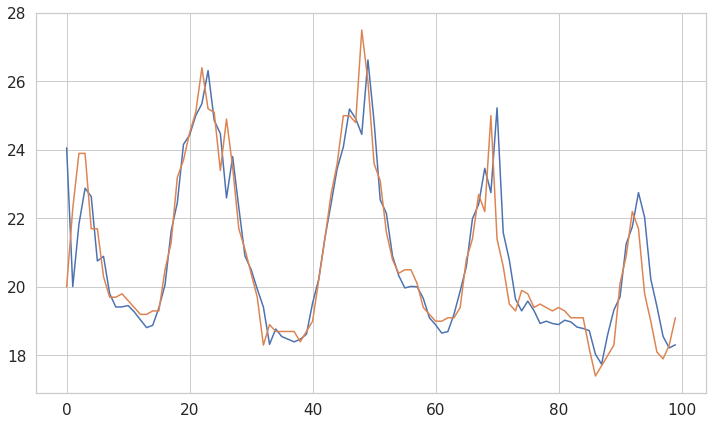

In [ ]:
plot_predictions1(model4, X2_test, y2_test)

In [ ]:
def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001):
  model = Sequential()
  model.add(InputLayer((5, 1)))
  model.add(Conv1D(64, kernel_size=2))
  model.add(Flatten())
  model.add(Dense(8, 'relu'))
  model.add(Dense(1, 'linear'))


  cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
  model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

  return model

In [ ]:
%%time
test_model = train_model_conv1d(X_train1, y_train1, X_val1, y_val1, 'test_model', epochs=100)

Epoch 1/100
2192/2192 [==============================] - 4s 2ms/step - loss: 24.0584 - root_mean_squared_error: 4.9049 - val_loss: 2.9800 - val_root_mean_squared_error: 1.7263
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 2/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.8432 - root_mean_squared_error: 1.3577 - val_loss: 1.6942 - val_root_mean_squared_error: 1.3016
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 3/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.3689 - root_mean_squared_error: 1.1700 - val_loss: 1.4972 - val_root_mean_squared_error: 1.2236
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 4/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2808 - root_mean_squared_error: 1.1317 - val_loss: 1.4551 - val_root_mean_squared_error: 1.2063
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 5/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2590 - root_mean_squared_error: 1.1221 - val_loss: 1.4351 - val_root_mean_squared_error: 1.1980
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 6/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2524 - root_mean_squared_error: 1.1191 - val_loss: 1.4277 - val_root_mean_squared_error: 1.1949
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 7/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2497 - root_mean_squared_error: 1.1179 - val_loss: 1.4177 - val_root_mean_squared_error: 1.1907
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 8/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2472 - root_mean_squared_error: 1.1168 - val_loss: 1.4254 - val_root_mean_squared_error: 1.1939
Epoch 9/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2490 - root_mean_squared_error: 1.1176 - val_loss: 1.4377 - val_root_mean_squared_error: 1.1990
Epoch 10/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2461 - root_mean_squared_error: 1.1163 - val_loss: 1.4228 - val_root_mean_squared_error: 1.1928
Epoch 11/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2473 - root_mean_squared_error: 1.1168 - val_loss: 1.4496 - val_root_mean_squared_error: 1.2040
Epoch 12/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2470 - root_mean_squared_error: 1.1167 - val_loss: 1.4221 - val_root_mean_squared_error: 1.1925
Epoch 13/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2459 - root_mean_squared_error: 1.1162 - v

INFO:tensorflow:Assets written to: test_model/assets


Epoch 15/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2462 - root_mean_squared_error: 1.1163 - val_loss: 1.4237 - val_root_mean_squared_error: 1.1932
Epoch 16/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2447 - root_mean_squared_error: 1.1157 - val_loss: 1.4292 - val_root_mean_squared_error: 1.1955
Epoch 17/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2445 - root_mean_squared_error: 1.1156 - val_loss: 1.4623 - val_root_mean_squared_error: 1.2092
Epoch 18/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2464 - root_mean_squared_error: 1.1164 - val_loss: 1.4158 - val_root_mean_squared_error: 1.1899
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 19/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2448 - root_mean_squared_error: 1.1157 - val_loss: 1.4281 - val_root_mean_squared_error: 1.1950
Epoch 20/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2459 - root_mean_squared_error: 1.1162 - val_loss: 1.4333 - val_root_mean_squared_error: 1.1972
Epoch 21/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2495 - root_mean_squared_error: 1.1178 - val_loss: 1.4176 - val_root_mean_squared_error: 1.1906
Epoch 22/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2478 - root_mean_squared_error: 1.1171 - val_loss: 1.4273 - val_root_mean_squared_error: 1.1947
Epoch 23/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2475 - root_mean_squared_error: 1.1169 - val_loss: 1.4204 - val_root_mean_squared_error: 1.1918
Epoch 24/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2497 - root_mean_squared_error: 1.1179 -

INFO:tensorflow:Assets written to: test_model/assets


Epoch 33/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2462 - root_mean_squared_error: 1.1163 - val_loss: 1.4169 - val_root_mean_squared_error: 1.1904
Epoch 34/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2452 - root_mean_squared_error: 1.1159 - val_loss: 1.4385 - val_root_mean_squared_error: 1.1994
Epoch 35/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2451 - root_mean_squared_error: 1.1158 - val_loss: 1.4160 - val_root_mean_squared_error: 1.1900
Epoch 36/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2445 - root_mean_squared_error: 1.1156 - val_loss: 1.4923 - val_root_mean_squared_error: 1.2216
Epoch 37/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2488 - root_mean_squared_error: 1.1175 - val_loss: 1.4152 - val_root_mean_squared_error: 1.1896
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 38/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2438 - root_mean_squared_error: 1.1153 - val_loss: 1.4153 - val_root_mean_squared_error: 1.1897
Epoch 39/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2438 - root_mean_squared_error: 1.1153 - val_loss: 1.4171 - val_root_mean_squared_error: 1.1904
Epoch 40/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2462 - root_mean_squared_error: 1.1163 - val_loss: 1.4231 - val_root_mean_squared_error: 1.1929
Epoch 41/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2439 - root_mean_squared_error: 1.1153 - val_loss: 1.4985 - val_root_mean_squared_error: 1.2241
Epoch 42/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2443 - root_mean_squared_error: 1.1155 - val_loss: 1.4282 - val_root_mean_squared_error: 1.1951
Epoch 43/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2457 - root_mean_squared_error: 1.1161 -

INFO:tensorflow:Assets written to: test_model/assets


Epoch 86/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2420 - root_mean_squared_error: 1.1145 - val_loss: 1.4148 - val_root_mean_squared_error: 1.1895
INFO:tensorflow:Assets written to: test_model/assets


INFO:tensorflow:Assets written to: test_model/assets


Epoch 87/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2417 - root_mean_squared_error: 1.1143 - val_loss: 1.4449 - val_root_mean_squared_error: 1.2020
Epoch 88/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2422 - root_mean_squared_error: 1.1146 - val_loss: 1.4164 - val_root_mean_squared_error: 1.1901
Epoch 89/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2431 - root_mean_squared_error: 1.1150 - val_loss: 1.4150 - val_root_mean_squared_error: 1.1895
Epoch 90/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2425 - root_mean_squared_error: 1.1147 - val_loss: 1.4355 - val_root_mean_squared_error: 1.1981
Epoch 91/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2440 - root_mean_squared_error: 1.1154 - val_loss: 1.4170 - val_root_mean_squared_error: 1.1904
Epoch 92/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2435 - root_mean_squared_error: 1.1151 -

INFO:tensorflow:Assets written to: test_model/assets


Epoch 96/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2405 - root_mean_squared_error: 1.1138 - val_loss: 1.4608 - val_root_mean_squared_error: 1.2086
Epoch 97/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2409 - root_mean_squared_error: 1.1140 - val_loss: 1.4169 - val_root_mean_squared_error: 1.1903
Epoch 98/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2419 - root_mean_squared_error: 1.1144 - val_loss: 1.4174 - val_root_mean_squared_error: 1.1905
Epoch 99/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2427 - root_mean_squared_error: 1.1147 - val_loss: 1.4205 - val_root_mean_squared_error: 1.1918
Epoch 100/100
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2421 - root_mean_squared_error: 1.1145 - val_loss: 1.4212 - val_root_mean_squared_error: 1.1921
CPU times: user 7min 28s, sys: 40.9 s, total: 8min 9s
Wall time: 6min 22s


(      Predictions  Actuals
 0       24.364063     20.0
 1       19.244774     22.3
 2       22.198639     23.9
 3       23.798664     23.9
 4       23.748337     21.7
 ...           ...      ...
 8761    27.348679     28.1
 8762    27.133282     23.6
 8763    21.978630     23.6
 8764    22.410475     22.3
 8765    21.173981     21.3
 
 [8766 rows x 2 columns], 1.2813420195246468)

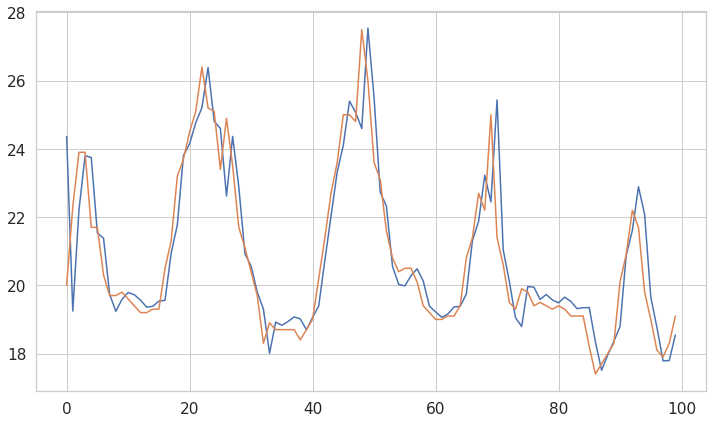

In [ ]:
plot_predictions1(test_model, X_test1, y_test1)

### SKEWNESS and KURTOSIS

In [ ]:
from scipy.stats import kurtosis
from statistics import mean, mode, median
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib import ticker

# Calculating coefficient of skewness ( Pearson's second coefficient of skewness )
skewness = (3 * (df['Temperature'].mean() - df['Temperature'].median())) / df['Temperature'].std()

print(f"Skewness: {round(skewness, 2)}")
print(f'Kurtosis: {round(kurtosis(df.Temperature), 2)}')

ax = sns.histplot(data=df, x='Temperature', kde=True)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} °C'))
plt.xticks(rotation=60)
plt.show()


# Calculating coefficient of skewness with log transformation ( Pearson's second coefficient of skewness )
df_log = np.log(df['Temperature'])
skewness_log = (3 * (df_log.mean() - df_log.median())) / df_log.std()

print(f"Skewness: {round(skewness_log, 2)}")
print(f'Kurtosis: {kurtosis(np.log(df["Temperature"]))}')
sns.histplot(data=df, x=np.log(df["Temperature"]), kde=True)
plt.xlabel('Temperature (Log Scale)')
plt.show()